In [1]:
import numpy as np
import caveclient
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import os
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
from dotmotif.ingest import CSVEdgelistConverter
from scipy import stats

In [2]:
raw_data = pd.read_feather('../data/Microns In Vivo Correlation Data v2/cell_cell_correlations.feather')
raw_data = raw_data.drop_duplicates(subset=['pt_root_id_1', 'pt_root_id_2'], keep='first')
# raw_data.columns
raw_data['pt_root_id_1'].dtype
# drop duplicates

raw_data = pd.concat([raw_data, raw_data.rename({'pt_root_id_1': 'pt_root_id_2', 'pt_root_id_2': 'pt_root_id_1'})]).reset_index(drop=True)
raw_data

,pt_root_id_1,pt_root_id_2,corr,scan_idx,session
0,864691135348268503,864691135700505634,0.018631,7,4
1,864691135348268503,864691135776919981,-0.005178,7,4
2,864691135348268503,864691135472842290,0.006708,7,4
3,864691135348268503,864691135349237975,0.020941,7,4
4,864691135345445279,864691135348268503,0.008743,7,4
...,...,...,...,...,...
13007153,864691135715713562,864691136267470324,0.058886,3,7
13007154,864691135715713562,864691135778113213,0.020464,3,7
13007155,864691135697182106,864691136267470324,0.011063,3,7
13007156,864691135697182106,864691135778113213,-0.029825,3,7


In [3]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "../data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"
    
data_dir = os.path.join(data_root, 'microns_in_silico')

# you can just override this if the location of the data varies
# data_dir = '/Users/forrestc/Downloads/microns_in_silico/'

In [4]:
# we are going to load up the data and prepare the dataframe like we did 
# in class but with fewer comments

# load up the in-silico responses as a pandas dataframe from a numpy array 
resp=pd.DataFrame(np.load(os.path.join(data_dir, 'nat_resp.npy')))

# load up the csv of metadata about the 104171 units
units_df = pd.read_csv(os.path.join(data_dir, 'nat_unit.csv'))

# set the index to the be the row_idx of the units_df
resp.index = units_df['row_idx']

# if we are on code ocean, the CAVEsetup helped you make your token an environment variable
if 'amzn' in platstring:
    client= caveclient.CAVEclient('minnie65_public', auth_token=os.environ['API_SECRET'])
else:
    # otherwise if you are local, then it should be saved to a file in your harddrive 
    # that the caveclient knows where to read.
    client= caveclient.CAVEclient('minnie65_public')

# lets pull out the manual coregistered neurons
# desired_resolution describes how many nanometers you want each unit to be
# so 1000,1000,1000 gives positions in microns for x,y and z
coreg_df = client.materialize.query_table('coregistration_manual_v3', desired_resolution=[1000,1000,1000])

# lets merge these dataframes so we get the row_idx of each coregistered unit
# we merge on the corresponding columns, however scan was called something
# slightly different in one csv vs the CAVE table
coreg_in_silico=pd.merge(units_df, coreg_df, 
         left_on=['scan_session', 'scan_idx', 'unit_id'],
          right_on=['session','scan_idx', 'unit_id'])
# reset the index to make sure that we have the index
coreg_in_silico.reset_index(inplace=True)
print(coreg_in_silico.shape)

# this will pull out the responses to the coregistered units
# by using the row_idx that was provided in the metadata
coreg_resp = resp.loc[coreg_in_silico.row_idx,:]

# now with a reduced set of units, we can calculate the Pearson correlation
# between their responses
corr_M = np.corrcoef(coreg_resp.values)

ct_df = client.materialize.query_table('aibs_soma_nuc_exc_mtype_preds_v117')
# lets merge it on the coregistered cells with in silico responses
# we will use the segment version is (pt_root_id) to do this
ct_merge_df=pd.merge(coreg_in_silico.reset_index(),
                     ct_df[['pt_root_id', 'id_ref', 'cell_type']],
                     on='pt_root_id')

# lets pull all the neurons where we can trust the axons
# as being reasonably well reconstructed
prf_df=client.materialize.query_table('proofreading_status_public_release', 
                                      filter_in_dict={'status_axon': ['extended', 'clean']})
print(prf_df.shape)
# how many of these are coregistered?
clean_coreg_df = pd.merge(prf_df, coreg_in_silico, on='pt_root_id')

# we need this code to work in solutions directory
# and one up..
workshop2file = 'all_prf_coreg_conn_v661.pkl'
all_syn_df = pd.read_pickle(workshop2file)

nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])

# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)

# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]


# now lets merge in our cell type calls
# by using suffixes we will name the pre and post synaptic cell type 
# differently
all_syn_dfm3=all_syn_dfm2.merge(ct_df[['target_id', 'cell_type']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(ct_df[['target_id', 'cell_type']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])

(12094, 23)
(1051, 10)


In [5]:
all_syn_dfm2.index_pre

0         1732
1         9201
2        10852
4         2145
5         2091
         ...  
36266      323
36270      323
36278      394
36282     8949
36283     8949
Name: index_pre, Length: 24782, dtype: int64

In [6]:
resp

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
row_idx,,,,,,,,,,,,,,,,,,,,,
0,9.819719,9.572107,9.575624,9.747010,9.971255,9.851794,10.146152,10.441845,10.554578,10.590077,...,10.074213,9.852283,9.957593,10.008598,9.929258,9.856516,9.963867,9.899036,9.846794,9.755130
1,5.824135,5.336558,5.128190,5.203142,5.506340,5.930792,6.528087,6.857086,7.117443,7.385743,...,5.238009,5.207496,5.200150,5.162911,5.277632,5.155036,5.286361,5.119339,5.125288,5.078022
2,5.691068,5.529594,5.803073,6.178924,6.443235,6.469791,6.654843,6.811019,6.661856,6.376816,...,5.361619,5.108631,4.880289,4.721966,4.654217,4.591662,4.486180,4.514648,4.727315,5.012149
3,3.548255,3.565851,3.518249,3.360956,2.990964,2.775848,2.678332,2.665106,2.672216,2.675659,...,3.610325,3.597228,3.585626,3.641256,3.775688,3.861930,3.925865,3.802548,3.864862,3.896344
4,6.361384,6.344265,6.517450,6.768298,6.822587,6.806442,7.249547,7.614173,7.614393,7.706423,...,6.779241,6.837814,6.838259,6.975827,6.713204,6.575862,6.436296,6.197456,6.013506,5.949809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104166,7.371026,7.391239,7.418334,7.503781,7.600024,7.725336,7.553344,7.385557,7.279595,7.234358,...,6.784002,6.663013,6.410810,6.328493,6.312036,6.344944,6.185144,6.152516,6.210687,6.497430
104167,36.203568,34.035812,31.154234,28.341587,27.045757,25.960541,25.018373,23.971766,23.934450,24.305433,...,29.859049,31.423447,31.123848,31.880001,32.174137,31.562712,31.853586,31.688009,31.952732,33.268524
104168,9.263451,9.338160,9.252237,8.782646,8.660838,8.405701,8.518544,8.542967,8.370674,8.318182,...,10.316454,10.185993,10.024368,9.652556,9.294561,8.994209,8.627438,8.604503,8.576520,8.645331


In [7]:
print(coreg_resp.values.shape)
print(corr_M.shape)

(12094, 5000)
(12094, 12094)


In [8]:
all_syn_dfm3

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,index_post,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,9470,8,5,8,9995,4.829187,12.58870,0.169119,L5ET,L5ET
1,864691136228183377,864691136310417242,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,9470,8,5,8,9995,4.829187,12.58870,0.010837,L4c,L5ET
2,864691135155894884,864691136310417242,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,9470,8,5,8,9995,4.829187,12.58870,0.040026,L2a,L5ET
3,864691135591041291,864691136310417242,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,9470,8,5,8,9995,4.829187,12.58870,0.145264,L2a,L5ET
4,864691136194822888,864691136310417242,1,9972,260697,303145,"[682.624, 583.36, 891.24]","[742.528, 824.896, 890.64]",4553,6,...,9470,8,5,8,9995,4.829187,12.58870,0.191115,L4a,L5ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,1,3232,560732,589247,"[1310.336, 760.896, 834.8]","[1343.104, 760.384, 928.8]",8446,7,...,889,4,7,8,8000,12.462448,4.24028,0.025147,L5ET,L5b
22851,864691135382556378,864691136106586585,1,7904,560732,586049,"[1310.336, 760.896, 834.8]","[1372.48, 581.696, 900.4]",8446,7,...,7600,7,3,4,5318,-8.373077,12.72040,-0.000407,L5ET,L4b
22852,864691135382556378,864691135916238182,1,7556,560732,653458,"[1310.336, 760.896, 834.8]","[1456.576, 561.024, 898.28]",8446,7,...,9564,9,3,2,1487,5.074941,10.86790,0.062903,L5ET,L3c
22853,864691135382556378,864691135387639681,1,1192,560732,615601,"[1310.336, 760.896, 834.8]","[1405.824, 661.568, 648.28]",8446,7,...,2613,5,7,6,6580,5.188042,6.35578,-0.128817,L5ET,L5ET


In [9]:
condensed = all_syn_dfm3[['pre_pt_root_id','post_pt_root_id','sum_size','index_pre','index_post','C','cell_type_pre','cell_type_post']]
condensed.to_csv('edgelist_corr_cell_types.csv')
CSV_EDGELIST = 'edgelist_corr_cell_types.csv'
condensed

,pre_pt_root_id,post_pt_root_id,sum_size,index_pre,index_post,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5ET,L5ET
1,864691136228183377,864691136310417242,7604,9201,9470,0.010837,L4c,L5ET
2,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2a,L5ET
3,864691135591041291,864691136310417242,25900,2091,9470,0.145264,L2a,L5ET
4,864691136194822888,864691136310417242,9972,4553,9470,0.191115,L4a,L5ET
...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,3232,8446,889,0.025147,L5ET,L5b
22851,864691135382556378,864691136106586585,7904,8446,7600,-0.000407,L5ET,L4b
22852,864691135382556378,864691135916238182,7556,8446,9564,0.062903,L5ET,L3c
22853,864691135382556378,864691135387639681,1192,8446,2613,-0.128817,L5ET,L5ET


In [10]:

# # Difine Dict with the key-value pair to remap.
# dict = {"Spark" : 'S', "PySpark" : 'P', "Hadoop": 'H', "Python" : 'P', "Pandas": 'P'}
# df2=df.replace({"Courses": dict})
# print(df2)
remap_dict = {'L2a':'L2/3', 'L2b':'L2/3', 
              'L3a':'L2/3', 'L3b':'L2/3', 'L3c':'L2/3', 
              'L4a':'L4', 'L4b':'L4', 'L4c':'L4',
              'L5ET':'L5', 'L5NP':'L5', 'L5a':'L5', 'L5b':'L5',
              'L6CT':'L6','L6a':'L6', 'L6b':'L6'}

df = condensed.replace({'cell_type_pre':remap_dict})
df = df.replace({'cell_type_post':remap_dict})
df

,pre_pt_root_id,post_pt_root_id,sum_size,index_pre,index_post,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5
1,864691136228183377,864691136310417242,7604,9201,9470,0.010837,L4,L5
2,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5
3,864691135591041291,864691136310417242,25900,2091,9470,0.145264,L2/3,L5
4,864691136194822888,864691136310417242,9972,4553,9470,0.191115,L4,L5
...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,3232,8446,889,0.025147,L5,L5
22851,864691135382556378,864691136106586585,7904,8446,7600,-0.000407,L5,L4
22852,864691135382556378,864691135916238182,7556,8446,9564,0.062903,L5,L2/3
22853,864691135382556378,864691135387639681,1192,8446,2613,-0.128817,L5,L5


In [11]:
# ctr = condensed_thresholded_remapped
# L4toL23_df = ctr[ (ctr['cell_type_pre'] == 'L4') & (ctr['cell_type_post'] == 'L2/3')]
# L4toL23_df

In [12]:
# ctr = condensed_thresholded_remapped
# L23toL23_df = ctr[ (ctr['cell_type_pre'] == 'L2/3') & (ctr['cell_type_post'] == 'L2/3')]
# L23toL23_df

In [13]:
# ctr = condensed_thresholded_remapped
# L23toL5_df = ctr[ (ctr['cell_type_pre'] == 'L2/3') & (ctr['cell_type_post'] == 'L5')]
# L23toL5_df

In [14]:
# L23toL5_df.to_csv('L23toL5_df.csv')
# CSV_EDGELIST_L23toL5_df = 'L23toL5_df.csv'

In [15]:
# L4toL23_df.to_csv('L4toL23_df.csv')
# CSV_EDGELIST_L4toL23_df = 'L4toL23_df.csv'

In [16]:
# L23toL23_df.to_csv('L23toL23_df.csv')
# CSV_EDGELIST_L23toL23_df = 'L23toL23_df.csv'

In [17]:
# # repeat motif analysis for raw data

# graph_thresh = CSVEdgelistConverter(
#     CSV_EDGELIST_L23toL5_df,
#     "pre_pt_root_id",
#     "post_pt_root_id",
# ).to_graph()

# # Create the search engine.
# E_L23toL5 = GrandIsoExecutor(graph=graph_thresh)

In [18]:
# # repeat motif analysis for raw data

# graph_thresh = CSVEdgelistConverter(
#     CSV_EDGELIST_L4toL23_df,
#     "pre_pt_root_id",
#     "post_pt_root_id",
# ).to_graph()

# # Create the search engine.
# E_L4toL23 = GrandIsoExecutor(graph=graph_thresh)

In [19]:
# # repeat motif analysis for raw data

# graph_thresh = CSVEdgelistConverter(
#     CSV_EDGELIST_L23toL23_df,
#     "pre_pt_root_id",
#     "post_pt_root_id",
# ).to_graph()

# # Create the search engine.
# E_L23toL23 = GrandIsoExecutor(graph=graph_thresh)

In [20]:
# repeat motif analysis for raw data

df.to_csv('all.csv')
CSV_EDGELIST_all = 'all.csv'

graph_thresh = CSVEdgelistConverter(
    CSV_EDGELIST_all,
    "pre_pt_root_id",
    "post_pt_root_id",
).to_graph()

# Create the search engine.
E_all = GrandIsoExecutor(graph=graph_thresh)

In [21]:

# 'L2/3', 'L4', 'L5', 'L6'
con_motif = Motif("""
A -> C
B -> C
""")

con_results_all = E_all.find(con_motif)
n_con = len(con_results_all)

div_motif = Motif("""
B -> A
B -> C
""")

div_results_all = E_all.find(div_motif)
n_div = len(div_results_all)

In [22]:
# con_idcs = np.zeros((len(con_results_raw),2))
d = {}
d['pt_root_id_1'] = np.zeros(len(con_results_all),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(con_results_all),dtype=np.int64)
for i, con_motif in enumerate(con_results_all):
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = bid
con_df = pd.DataFrame(data=d)
# print(con_df)
con_df_shuffled = con_df.copy()
con_df_shuffled['pt_root_id_1'] = np.random.permutation(con_df['pt_root_id_1'].values)
# print(con_df_shuffled)

In [23]:
d = {}
d['pt_root_id_1'] = np.zeros(len(div_results_all),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(div_results_all),dtype=np.int64)
for i, div_motif in enumerate(div_results_all):
    aid = np.int64(div_motif['A'])
    cid = np.int64(div_motif['C'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = cid
div_df = pd.DataFrame(data=d)
div_df_shuffled = div_df.copy()
div_df_shuffled['pt_root_id_1'] = np.random.permutation(div_df['pt_root_id_1'].values)

In [24]:
con_corr_shuffled = con_df_shuffled.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
con_corr_shuffled

,pt_root_id_1,pt_root_id_2,corr,scan_idx,session
0,864691135292991414,864691136194822888,0.023728,4,6
1,864691135292991414,864691136194822888,0.023728,4,6
2,864691135292991414,864691136194822888,0.023728,4,6
3,864691135292991414,864691136194822888,0.023728,4,6
4,864691135645645039,864691135759091534,-0.014251,7,4
...,...,...,...,...,...
16685,864691135213650232,864691135491204327,0.153291,4,6
16686,864691134884807418,864691135700409211,0.037932,5,8
16687,864691134884807418,864691135700409211,0.037932,5,8
16688,864691135725354411,864691136108938168,-0.004033,7,4


In [25]:
div_corr_shuffled = div_df_shuffled.merge(raw_data,how='inner',on=['pt_root_id_1','pt_root_id_2'])
div_corr_shuffled

,pt_root_id_1,pt_root_id_2,corr,scan_idx,session
0,864691135440543560,864691135777867616,-0.014072,4,6
1,864691135440543560,864691135777867616,-0.014072,4,6
2,864691135446543762,864691136310417242,0.038857,5,8
3,864691135446543762,864691136310417242,0.038857,5,8
4,864691135446543762,864691136310417242,0.038857,5,8
...,...,...,...,...,...
198959,864691135502982581,864691136602354129,0.010748,5,8
198960,864691135446543762,864691135498671379,0.115413,7,4
198961,864691135446543762,864691135498671379,0.115413,7,4
198962,864691135783332915,864691136310810202,0.081848,4,6


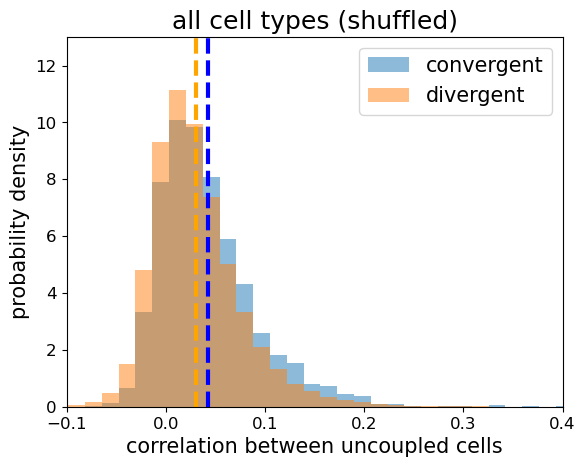

In [30]:
fig,ax = plt.subplots()
con_corrs_shuffled = con_corr_shuffled[['corr']]
div_corrs_shuffled = div_corr_shuffled[['corr']]
ax.hist(con_corrs_shuffled,density=True,bins=np.linspace(-.2, .8, 60),label='convergent',alpha=0.5)
ax.hist(div_corrs_shuffled,density=True,bins=np.linspace(-.2, .8, 60),label='divergent',alpha=0.5)
# ax.hist(con_corrs_raw_thresh,density=True,label='convergent',alpha=0.5)
# ax.hist(div_corrs_raw_thresh,density=True,label='divergent',alpha=0.5)
con_mean_shuffled = np.mean(con_corrs_shuffled)
div_mean_shuffled = np.mean(div_corrs_shuffled)
ax.vlines(con_mean_shuffled,0,13,linestyle='--',linewidth=3,color='blue')
ax.vlines(div_mean_shuffled,0,13,linestyle='--',linewidth=3,color='orange')
ax.set_ylim([0,13])
# print(stats.ks_2samp(con_corrs_raw, div_corrs_raw))
ax.set_title(r'all cell types (shuffled)',fontsize=18)
ax.set_xlabel('correlation between uncoupled cells',fontsize=15)
ax.set_ylabel('probability density',fontsize=15)
ax.set_xlim([-0.1,0.4])
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
plt.legend(fontsize=15)
# plt.legend()
plt.savefig('allCellTypesShuffledCorrs.png',bbox_inches='tight',dpi=200)
plt.show()

In [27]:
L23toL5_df = df[ (df['cell_type_pre'] == 'L2/3') & (df['cell_type_post'] == 'L5')]
# L23toL5_df

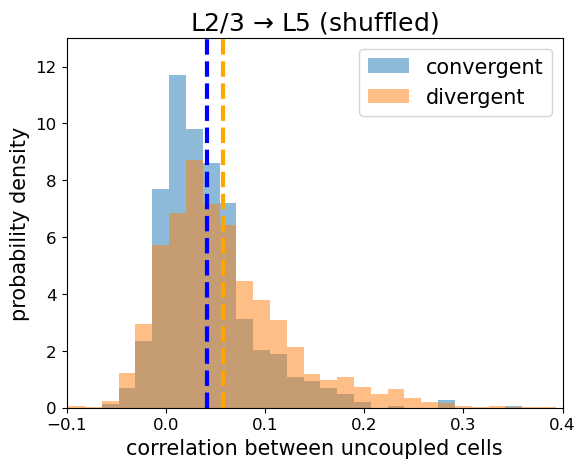

In [32]:
L23toL5_df.to_csv('L23toL5_df.csv')
CSV_EDGELIST_L23toL5 = 'L23toL5_df.csv'
graph_thresh = CSVEdgelistConverter(
    CSV_EDGELIST_L23toL5,
    "pre_pt_root_id",
    "post_pt_root_id",
).to_graph()
# Create the search engine.
E_L23toL5 = GrandIsoExecutor(graph=graph_thresh)
con_motif = Motif("""
A -> C
B -> C
""")
con_results_L23toL5 = E_L23toL5.find(con_motif)
n_con = len(con_results_L23toL5)
div_motif = Motif("""
B -> A
B -> C
""")
div_results_L23toL5 = E_L23toL5.find(div_motif)
n_div = len(div_results_L23toL5)
# con_idcs = np.zeros((len(con_results_raw),2))
d = {}
d['pt_root_id_1'] = np.zeros(len(con_results_L23toL5),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(con_results_L23toL5),dtype=np.int64)
for i, con_motif in enumerate(con_results_L23toL5):
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = bid
con_df = pd.DataFrame(data=d)
con_df_shuffled = con_df.copy()
con_df_shuffled['pt_root_id_1_shuf'] = np.random.permutation(con_df['pt_root_id_1'].values)
d = {}
d['pt_root_id_1'] = np.zeros(len(div_results_L23toL5),dtype=np.int64)
d['pt_root_id_2'] = np.zeros(len(div_results_L23toL5),dtype=np.int64)
for i, div_motif in enumerate(div_results_L23toL5):
    aid = np.int64(div_motif['A'])
    cid = np.int64(div_motif['C'])
    d['pt_root_id_1'][i] = aid
    d['pt_root_id_2'][i] = cid
div_df = pd.DataFrame(data=d)
div_df_shuffled = div_df.copy()
div_df_shuffled['pt_root_id_1_shuf'] = np.random.permutation(div_df['pt_root_id_1'].values)
con_corr_shuffled = con_df_shuffled.merge(raw_data.rename(columns={'pt_root_id_1':'pt_root_id_1_shuf'}),how='inner',on=['pt_root_id_1_shuf','pt_root_id_2'])
div_corr_shuffled = div_df_shuffled.merge(raw_data.rename(columns={'pt_root_id_1':'pt_root_id_1_shuf'}),how='inner',on=['pt_root_id_1_shuf','pt_root_id_2'])
fig,ax = plt.subplots()
con_corrs_shuffled = con_corr_shuffled[['corr']]
div_corrs_shuffled = div_corr_shuffled[['corr']]
ax.hist(con_corrs_shuffled,density=True,bins=np.linspace(-.2, .8, 60),label='convergent',alpha=0.5)
ax.hist(div_corrs_shuffled,density=True,bins=np.linspace(-.2, .8, 60),label='divergent',alpha=0.5)
con_mean_shuffled = np.mean(con_corrs_shuffled)
div_mean_shuffled = np.mean(div_corrs_shuffled)
ax.vlines(con_mean_shuffled,0,13,linestyle='--',linewidth=3,color='blue')
ax.vlines(div_mean_shuffled,0,13,linestyle='--',linewidth=3,color='orange')
# print(stats.ks_2samp(con_corrs_raw, div_corrs_raw))
ax.set_title(r'L2/3 $\to$ L5 (shuffled)',fontsize=18)
ax.set_xlabel('correlation between uncoupled cells',fontsize=15)
ax.set_ylabel('probability density',fontsize=15)
ax.set_xlim([-0.1,0.4])
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
plt.legend(fontsize=15)
ax.set_ylim([0,13])
# plt.legend()
plt.savefig('L23to5shuffledCorrs.png',bbox_inches='tight',dpi=200)
plt.show()